In [1]:
import os


import pandas as pd
import numpy as np
# import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from cal_feature import *
from plot_transient import *
from plot_feature1 import *
from plot_feature2 import *
from myMedFilter import *
from myHeatMap import *
from myScatter import *
from linearRegression import *

In [2]:
# define local directions
file_forder = "./transient_timeDomain/" 
up_dir = "./up_edge/"
down_dir = "./down_edge/"
up_pic_dir = "./up_edge_pic/"
down_pic_dir = "./down_edge_pic/"
feature_pic_dir = "./feature_pic/"
# save flag
SAVE_TRANSIENT = True
SAVE_SAMPLE = True
# plot flag
PLOT_TRANSIENT = True
PLOT_FEATURE = True
# feature flag
PRE_SLICE = 30
DUR_SLICE = 1024
SUB_SAMPLE = 2
NUM_MEAN = 15
DROP_OUTLIERS = True
CORR_TRESH1 = 0.99
CORR_TRESH2 = 0.6
# train flag
NUM_SPLIT = 370
BATCH_SIZE = 256
NUM_HIDEN1 = 32
NUM_HIDEN2 = 32
DROPOUT = 0.0
NUM_EPOCH = 40000
# proceed flag
IS_SLICE = True
IS_EXPAND = True
IS_TRAIN = True
# debug mode
DEBUG_MODE = False

# slice data while switching 
### 1. up-edge 
### 2. down-edge

In [3]:
# slice data
if IS_SLICE:
    if DEBUG_MODE:
        SAVE_TRANSIENT = False
        PLOT_TRANSIENT = True
        PRE_SLICE = 30
        DUR_SLICE = 512

    for (_ ,_ , process_files) in os.walk(file_forder):
        for file in process_files:
            sample_df = pd.read_csv(file_forder + file )
            sample_name = file[:-4]
            # get index in up and down edge
            n = np.where(sample_df.gateSignalVoltage.values>8)  # return a tuple so use n[0][0] to index
            # slice data
            up_df = sample_df.iloc[n[0][0]-PRE_SLICE:n[0][0]+DUR_SLICE-PRE_SLICE,:]
            down_df = sample_df.iloc[n[0][-1]-PRE_SLICE:n[0][-1]+DUR_SLICE-PRE_SLICE,:]
            # expand feature
            up_df = up_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            up_df["P"] = up_df["gateEmitterVoltage"]*up_df["collectorEmitterVoltage"]
            down_df = down_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            down_df["P"] = down_df["gateEmitterVoltage"]*down_df["collectorEmitterVoltage"]
            # save data
            if SAVE_TRANSIENT:
                up_df.to_csv(up_dir+file,index = False)
                down_df.to_csv(down_dir+file,index = False)
            # plot data
            if PLOT_TRANSIENT:
                plot_transient(down_df,sample_name, down_pic_dir)
                plot_transient(up_df,sample_name,up_pic_dir)

    # show info
    # print(sample_df.shape)
    # print(sample_df.columns)
    # sample_df.head()

# featuring

### extract features

In [4]:
# define local directions
up_dir = "./up_edge/"
down_dir = "./down_edge/"
if DEBUG_MODE:
    SUB_SAMPLE = 8
    SAVE_SAMPLE = True
    NUM_MEAN = 20
#  down edge
all_feature_df = pd.DataFrame()
for (_ ,_ , process_files) in os.walk(file_forder):
    for file in process_files:
        # read file
        sample_df = pd.read_csv(down_dir+file)
        sample_df.fillna(method = "backfill",inplace = True)
        # calculate features
        for i in range(SUB_SAMPLE):
            subsample_df = sample_df.loc[i::SUB_SAMPLE,:]
            if SAVE_SAMPLE:
                subsample_df.to_csv(down_dir+file[0:-4]+"_"+str(i)+".csv",index = False)
            cols = sample_df.columns
            feature_df = pd.DataFrame()
            for col in cols:
                df = cal_feature(subsample_df, col)
                feature_df = pd.concat([feature_df,df],axis = 1)
            feature_df["Vce_pre"] = np.mean(sample_df['collectorEmitterVoltage'].values[:NUM_MEAN])
            feature_df["P_pre"] = np.mean(sample_df['P'].values[:NUM_MEAN])
            feature_df['round'] = int(file[0:-4])

            all_feature_df = pd.concat([all_feature_df,feature_df],axis = 0)

all_feature_df.sort_values(by = 'round', inplace=True)    
all_feature_df.to_csv('./temp/down_edge_features_subsample.csv',index = False)

# up edge
all_feature_df = pd.DataFrame()
for (_ ,_ , process_files) in os.walk(file_forder):
    for file in process_files:
        # read file
        sample_df = pd.read_csv(up_dir+file)
        sample_df.fillna(method = "backfill",inplace = True)
        # calculate features
        for i in range(SUB_SAMPLE):
            subsample_df = sample_df.loc[i::SUB_SAMPLE,:]
            if SAVE_SAMPLE:
                subsample_df.to_csv(up_dir+file[0:-4]+"_"+str(i)+".csv",index = False)
            cols = sample_df.columns
            feature_df = pd.DataFrame()
            for col in cols:
                df = cal_feature(subsample_df, col)
                feature_df = pd.concat([feature_df,df],axis = 1)
            feature_df["Vce_post"] = np.mean(sample_df['collectorEmitterVoltage'].values[-NUM_MEAN:])
            feature_df["P_post"] = np.mean(sample_df['P'].values[-NUM_MEAN:])
            feature_df['round'] = int(file[0:-4])

            all_feature_df = pd.concat([all_feature_df,feature_df],axis = 0)

all_feature_df.sort_values(by = 'round', inplace=True)    
all_feature_df.to_csv('./temp/up_edge_features_subsample.csv',index = False)

print(all_feature_df.shape)
all_feature_df.head()

(836, 107)


,gateSignalVoltage_min,gateSignalVoltage_max,gateSignalVoltage_range,gateSignalVoltage_mean,gateSignalVoltage_mode,gateSignalVoltage_median,gateSignalVoltage_quantile25,gateSignalVoltage_quantile75,gateSignalVoltage_std,gateSignalVoltage_var,...,P_sf,P_MI,P_CF,P_llr,P_pi,P_sdif,P_cpt1,Vce_post,P_post,round
0,-0.156250,10.546875,10.703126,9.724121,10.0,10.0,9.921875,10.078125,1.597118,2.550786,...,1.022301,1.218721,1.162055,1.817142,1.149251,0.218630,1.177462,3.187500,31.543622,1
0,-0.078125,10.546875,10.625001,9.724579,10.0,10.0,9.921875,10.078125,1.561497,2.438273,...,1.021926,1.213312,1.158355,1.829412,1.144862,0.216136,1.172105,3.187500,31.543622,1
0,-0.156250,10.312500,10.468751,9.697876,10.0,10.0,9.921875,10.078125,1.605589,2.577917,...,1.022013,1.287735,1.229755,2.033090,1.210803,0.218108,1.238738,2.187500,21.612952,2
0,-0.156250,10.546875,10.703126,9.722290,10.0,10.0,9.921875,10.078125,1.581890,2.502376,...,1.021325,1.311818,1.255872,2.046394,1.226166,0.215883,1.251906,2.187500,21.612952,2
0,-0.156250,10.390625,10.546876,9.684754,10.0,10.0,9.921875,10.000000,1.603022,2.569680,...,1.025754,1.335525,1.268064,1.934371,1.241066,0.234951,1.272410,2.104166,20.865067,3


### conband the up and down features

In [5]:
# conband the up and down features
up_df = pd.read_csv('./temp/up_edge_features_subsample.csv')
down_df = pd.read_csv('./temp/down_edge_features_subsample.csv')
# rename cosls
up_cols = ['up_'+c for c in up_df.columns]
down_cols = ['down_'+c for c in down_df.columns]
up_df.columns = up_cols
down_df.columns = down_cols
up_df.rename(columns={"up_round":"round"},inplace = True)
down_df.rename(columns={"down_round":"round"},inplace = True)
# merge
train_df = pd.merge(up_df,down_df, how="left",on = "round" )
# save
train_df.to_csv("./temp/train_feature_df_subsample.csv",index = False)
print(train_df.shape)
train_df.head()

(1672, 213)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_I,down_P_sf,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre
0,-0.156250,10.546875,10.703126,9.724121,10.0,10.0,9.921875,10.078125,1.597118,2.550786,...,7.110555,2.230075,27.600132,3.378373,0.304347,7.181413,2.000171,26.048797,4.483333,44.015951
1,-0.156250,10.546875,10.703126,9.724121,10.0,10.0,9.921875,10.078125,1.597118,2.550786,...,7.132213,2.233655,27.883177,3.428963,0.304542,7.202607,2.004123,25.964963,4.483333,44.015951
2,-0.078125,10.546875,10.625001,9.724579,10.0,10.0,9.921875,10.078125,1.561497,2.438273,...,7.110555,2.230075,27.600132,3.378373,0.304347,7.181413,2.000171,26.048797,4.483333,44.015951
3,-0.078125,10.546875,10.625001,9.724579,10.0,10.0,9.921875,10.078125,1.561497,2.438273,...,7.132213,2.233655,27.883177,3.428963,0.304542,7.202607,2.004123,25.964963,4.483333,44.015951
4,-0.156250,10.312500,10.468751,9.697876,10.0,10.0,9.921875,10.078125,1.605589,2.577917,...,7.821512,2.000763,15.213873,4.032254,0.505962,9.514048,1.825845,14.749833,2.031250,19.962561


### add temperature 

In [6]:
# add temperature
train_df = pd.read_csv('./temp/train_feature_df_subsample.csv')
tempareture_df = pd.read_csv("collectorEmitterVoltage_peak_temperature.csv")
train_df = pd.merge(train_df,tempareture_df, how="left",on = "round" )
# change the target num
train_df.rename(columns={"round":"num_cycle"},inplace = True)
# save
train_df.to_csv("./temp/train_feature_df_subsample.csv",index = False)

print(train_df.shape)
train_df.head()

(1672, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,-0.156250,10.546875,10.703126,9.724121,10.0,10.0,9.921875,10.078125,1.597118,2.550786,...,27.600132,3.378373,0.304347,7.181413,2.000171,26.048797,4.483333,44.015951,11.937499,47.211104
1,-0.156250,10.546875,10.703126,9.724121,10.0,10.0,9.921875,10.078125,1.597118,2.550786,...,27.883177,3.428963,0.304542,7.202607,2.004123,25.964963,4.483333,44.015951,11.937499,47.211104
2,-0.078125,10.546875,10.625001,9.724579,10.0,10.0,9.921875,10.078125,1.561497,2.438273,...,27.600132,3.378373,0.304347,7.181413,2.000171,26.048797,4.483333,44.015951,11.937499,47.211104
3,-0.078125,10.546875,10.625001,9.724579,10.0,10.0,9.921875,10.078125,1.561497,2.438273,...,27.883177,3.428963,0.304542,7.202607,2.004123,25.964963,4.483333,44.015951,11.937499,47.211104
4,-0.156250,10.312500,10.468751,9.697876,10.0,10.0,9.921875,10.078125,1.605589,2.577917,...,15.213873,4.032254,0.505962,9.514048,1.825845,14.749833,2.031250,19.962561,25.468751,124.804264


# drop outliers

In [7]:
if DEBUG_MODE:
    PLOT_FEATURE = False
    DROP_OUTLIERS = True
# drop outl
round_num_del = [1,2,3,4,5,6,7,8,9,10,11,12,13,24,35,46,112,223,334,386,375,364,
                 56,153,208,309,327,347,351,360,365,391
                ]

train_df = pd.read_csv('./temp/train_feature_df_subsample.csv')
if DROP_OUTLIERS:
    for num in round_num_del:
        train_df = train_df.loc[train_df['num_cycle'].values != num,:]
try:
    train_df = train_df.loc[train_df['temperature']>326,:]
except:
    train_df.rename(columns={"tempareture":"temperature"},inplace = True)
    train_df = train_df.loc[train_df['temperature']>326,:]
if PLOT_FEATURE:
    plot_feature1(train_df,"num_cycle",feature_pic_dir)
train_df.to_csv("./temp/train_feature_df_outliers_subsample.csv",index = False)

# show info
print(train_df.shape)
train_df.head()

(1532, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
64,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,8.769089,2.827212,0.558437,5.845987,1.583419,8.293247,1.770834,17.385419,9.937499,329.912613
65,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,8.759636,2.829216,0.559110,5.885543,1.586223,8.284307,1.770834,17.385419,9.937499,329.912613
66,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,8.769089,2.827212,0.558437,5.845987,1.583419,8.293247,1.770834,17.385419,9.937499,329.912613
67,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,8.759636,2.829216,0.559110,5.885543,1.586223,8.284307,1.770834,17.385419,9.937499,329.912613
68,-0.15625,10.312500,10.468751,9.691468,10.0,10.0,9.921875,10.078125,1.623418,2.635485,...,8.591234,2.844571,0.568854,6.018673,1.585045,8.127589,1.750000,17.162112,10.249999,327.237079


## filter

In [8]:
if DEBUG_MODE:
    PLOT_FEATURE = True
# filter
if False:
    train_df = pd.read_csv('./temp/train_feature_df_outliers.csv')
    train_df = pd.read_csv('./temp/train_feature_df.csv')
    train_df.drop(round_num_del,axis = 0,inplace = True)
    cols = [c for c in train_df.columns if c!="num_cycle"]
    for c in cols:
        train_df[c] = myMedFilter(train_df[c].values)
    if PLOT_FEATURE:
        plot_feature2(train_df,"num_cycle",feature_pic_dir)
    train_df.to_csv("./temp/train_feature_df_outliers_filter.csv",index = False)

    # show info
    print(train_df.shape)
    train_df.head()

# correlation

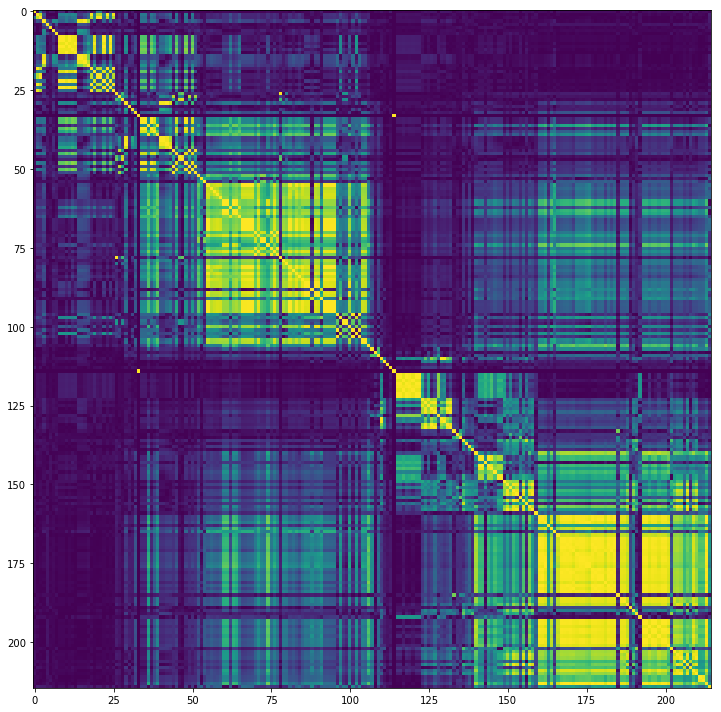

In [9]:
# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_feature_df_outliers_filter.csv')
corr_df = train_df.corr().abs()
corr_df.to_csv("temp/coelationship_outliners.csv")
# plot
im =np.abs(corr_df.values) 
plt.figure(figsize = (10,10))
plt.imshow(im)
plt.tight_layout()
plt.savefig('temp/correlationship'+'.png')


# feature select

In [10]:
if DEBUG_MODE:
    CORR_TRESH1 = 0.99
    CORR_TRESH2 = 0.6
# calculate corr
# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_feature_df_outliers_filter.csv')
corr_df = train_df.corr().abs()

# collect the duplicate cols
cols = train_df.columns.values
del_cols = []
for i in range(cols.size):
    for j in range(i+1,cols.size,1):
        if(corr_df.iloc[i,j]>CORR_TRESH1):
            if(cols[j] not in del_cols):
                del_cols.append(cols[j])
print("length of delete cols:",len(del_cols))

train_df.drop(del_cols,axis = 1,inplace= True)
corr_df = train_df.corr().abs()
corr_df.sort_values(by = 'num_cycle',axis = 0, ascending=False, inplace = True)
l = corr_df.index.to_series()
x = corr_df.loc[:,'num_cycle']>CORR_TRESH2
cols = l[x].values
print("feature length:",len(cols)-1)
print(cols)
corr_df.head()

length of delete cols: 80
feature length: 19
['num_cycle' 'down_collectorEmitterVoltage_llr'
 'up_collectorEmitterVoltage_llr' 'down_P_mean'
 'down_collectorEmitterVoltage_mean' 'down_collectorEmitterVoltage_max'
 'up_collectorEmitterVoltage_std' 'down_P_max' 'down_P_arv' 'down_P_sdif'
 'down_P_skew' 'down_P_sf' 'down_collectorEmitterVoltage_median'
 'down_gateEmitterVoltage_kurt' 'up_gateEmitterVoltage_skew'
 'down_collectorEmitterVoltage_quantile75' 'down_P_MI' 'down_P_I'
 'down_P_llr' 'up_collectorEmitterVoltage_sf']


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_skew,...,down_P_I,down_P_sf,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_Vce_pre,down_P_pre,temperature
num_cycle,0.026058,0.105620,0.108568,0.066293,0.030824,0.043378,0.042521,0.029450,0.039899,0.015451,...,0.633622,0.669117,0.637875,0.467853,0.624827,0.440245,0.688222,0.365722,0.382681,0.170949
down_collectorEmitterVoltage_llr,0.033485,0.001144,0.013152,0.003507,0.053561,0.023102,0.023349,0.008544,0.023223,0.010469,...,0.851536,0.864638,0.831106,0.669990,0.778155,0.693188,0.924994,0.628080,0.636231,0.563699
up_collectorEmitterVoltage_llr,0.028152,0.142931,0.143903,0.097818,0.069121,0.046797,0.042168,0.002256,0.199513,0.231335,...,0.634279,0.645790,0.629019,0.506404,0.575803,0.513562,0.691250,0.497074,0.509303,0.194505
down_P_mean,0.050622,0.004442,0.025580,0.005784,0.055598,0.020448,0.017805,0.015772,0.015680,0.003686,...,0.885516,0.955513,0.929757,0.613636,0.918602,0.524755,0.949757,0.679001,0.697363,0.476123
down_collectorEmitterVoltage_mean,0.031070,0.006419,0.019109,0.028969,0.055504,0.016023,0.029097,0.011302,0.017178,0.005532,...,0.818235,0.819937,0.800228,0.666453,0.718626,0.718184,0.898966,0.753129,0.756885,0.442408


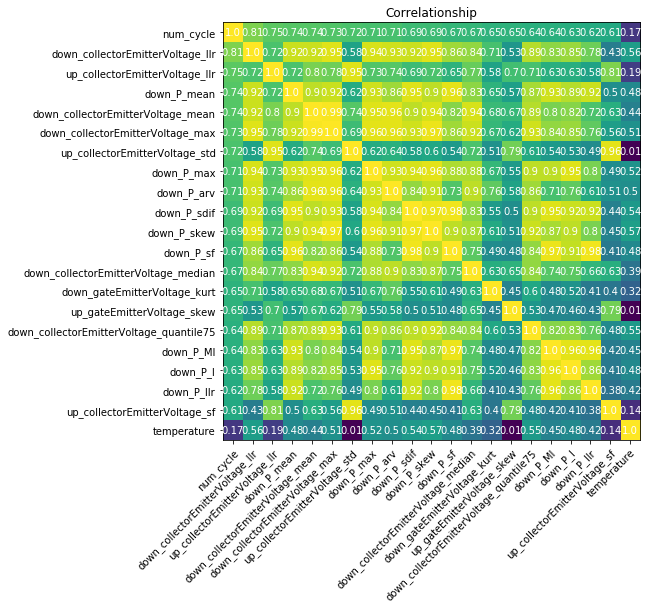

In [11]:
from myHeatMap import *
if 'temperature' not in cols:
    cols = np.append(cols,'temperature')

# train_df = pd.read_csv('./temp/train_feature_df.csv')
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
# train_df = pd.read_csv('./temp/train_df_scale.csv')
feature_df = train_df.loc[:,cols]
feature_df.to_csv('./temp/useful_feature_df.csv',index = False)
corr_df = feature_df.corr().abs()
corr_df.to_csv("temp/correlationship_usefue_features.csv")
# plot
im =np.abs(corr_df.values) 
im = im.round(2)
myHeatMap(im,cols,cols)

### scale to [0, 1]

In [12]:
# std
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
print(train_df.shape)
# drop_duplicates
train_df.drop_duplicates(subset = ['num_cycle','down_collectorEmitterVoltage_llr','up_collectorEmitterVoltage_llr'],inplace = True)
target = ["temperature","num_cycle"]
cols_to_use = [c for c in cols if c not in target]
for col in cols_to_use:
    ma = train_df[col].max()
    mi = train_df[col].min()
    train_df[col] = (train_df[col]-mi)/(ma-mi)
    
train_df.to_csv("temp/train_df_scale_subsample.csv",index = False)
print(train_df.shape)
train_df.head()

(1532, 215)
(1532, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,0.434477,2.827212,0.458698,5.845987,0.467114,8.293247,1.770834,17.385419,9.937499,329.912613
1,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,0.431221,2.829216,0.466351,5.885543,0.488995,8.284307,1.770834,17.385419,9.937499,329.912613
2,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,0.434477,2.827212,0.458698,5.845987,0.467114,8.293247,1.770834,17.385419,9.937499,329.912613
3,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,0.431221,2.829216,0.466351,5.885543,0.488995,8.284307,1.770834,17.385419,9.937499,329.912613
4,-0.15625,10.312500,10.468751,9.691468,10.0,10.0,9.921875,10.078125,1.623418,2.635485,...,0.373219,2.844571,0.577251,6.018673,0.479808,8.127589,1.750000,17.162112,10.249999,327.237079


### try some Nueral Network

In [13]:
train_df = pd.read_csv( "./temp/train_df_scale_subsample.csv")
print(train_df.shape)
train_df.head()

(1532, 215)


,up_gateSignalVoltage_min,up_gateSignalVoltage_max,up_gateSignalVoltage_range,up_gateSignalVoltage_mean,up_gateSignalVoltage_mode,up_gateSignalVoltage_median,up_gateSignalVoltage_quantile25,up_gateSignalVoltage_quantile75,up_gateSignalVoltage_std,up_gateSignalVoltage_var,...,down_P_MI,down_P_CF,down_P_llr,down_P_pi,down_P_sdif,down_P_cpt1,down_Vce_pre,down_P_pre,collectorEmitterVoltage_peak,temperature
0,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,0.434477,2.827212,0.458698,5.845987,0.467114,8.293247,1.770834,17.385419,9.937499,329.912613
1,-0.15625,10.234375,10.390626,9.683838,10.0,10.0,9.921875,10.078125,1.609616,2.590864,...,0.431221,2.829216,0.466351,5.885543,0.488995,8.284307,1.770834,17.385419,9.937499,329.912613
2,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,0.434477,2.827212,0.458698,5.845987,0.467114,8.293247,1.770834,17.385419,9.937499,329.912613
3,-0.15625,10.390625,10.546876,9.708100,10.0,10.0,9.921875,10.078125,1.580632,2.498397,...,0.431221,2.829216,0.466351,5.885543,0.488995,8.284307,1.770834,17.385419,9.937499,329.912613
4,-0.15625,10.312500,10.468751,9.691468,10.0,10.0,9.921875,10.078125,1.623418,2.635485,...,0.373219,2.844571,0.577251,6.018673,0.479808,8.127589,1.750000,17.162112,10.249999,327.237079


# prepare data

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
if DEBUG_MODE:
    NUM_SPLIT = 370

train_df = pd.read_csv( "./temp/train_df_scale_subsample.csv")
train_df["temperature"] = (train_df["temperature"] - 326)/5.0
target = ["num_cycle"]
if 'temperature' not in cols:
    cols = np.append(cols,'temperature')
cols = [c for c in cols if c not in target]
num_input = len(cols)
print(cols)
# get data
x_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,cols].values
y_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,"num_cycle"].values/100.0
x_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT,cols].values
y_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT,"num_cycle"].values/100.0
# astype
x_train = torch.tensor(x_train,dtype = torch.float32 )
y_train = torch.tensor(y_train,dtype = torch.float32)
y_train = y_train.unsqueeze_(1)
x_test = torch.tensor(x_test,dtype = torch.float32 )
y_test = torch.tensor(y_test,dtype = torch.float32)
y_test = y_test.unsqueeze_(1)
# split

print("train data size",x_train.shape)
print("train label size",y_train.shape)
print("test data size",x_test.shape)
print("test label size",y_test.shape)

['down_collectorEmitterVoltage_llr', 'up_collectorEmitterVoltage_llr', 'down_P_mean', 'down_collectorEmitterVoltage_mean', 'down_collectorEmitterVoltage_max', 'up_collectorEmitterVoltage_std', 'down_P_max', 'down_P_arv', 'down_P_sdif', 'down_P_skew', 'down_P_sf', 'down_collectorEmitterVoltage_median', 'down_gateEmitterVoltage_kurt', 'up_gateEmitterVoltage_skew', 'down_collectorEmitterVoltage_quantile75', 'down_P_MI', 'down_P_I', 'down_P_llr', 'up_collectorEmitterVoltage_sf', 'temperature']
train data size torch.Size([1348, 20])
train label size torch.Size([1348, 1])
test data size torch.Size([180, 20])
test label size torch.Size([180, 1])


In [15]:
from torch.utils.data import DataLoader
from myDataset import *
if DEBUG_MODE:
    BATCH_SIZE = 1024

train_set = myDataset(x_train,y_train)
test_set = myDataset(x_test,y_test)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

use gpu: True
step:[1000], train loss: 0.091186, test loss: 0.394685
step:[2000], train loss: 0.093730, test loss: 0.228462
step:[3000], train loss: 0.072198, test loss: 0.149016
step:[4000], train loss: 0.064412, test loss: 0.128878
step:[5000], train loss: 0.059433, test loss: 0.121937
step:[6000], train loss: 0.074140, test loss: 0.127341
step:[7000], train loss: 0.063422, test loss: 0.110608
step:[8000], train loss: 0.064004, test loss: 0.114647
step:[9000], train loss: 0.055225, test loss: 0.097276
step:[10000], train loss: 0.095008, test loss: 0.107794
step:[11000], train loss: 0.059443, test loss: 0.108279
step:[12000], train loss: 0.064790, test loss: 0.100220
step:[13000], train loss: 0.057120, test loss: 0.101965
step:[14000], train loss: 0.053622, test loss: 0.110453
step:[15000], train loss: 0.062469, test loss: 0.093036
step:[16000], train loss: 0.064443, test loss: 0.106851
step:[17000], train loss: 0.086215, test loss: 0.103105
step:[18000], train loss: 0.063251, test lo

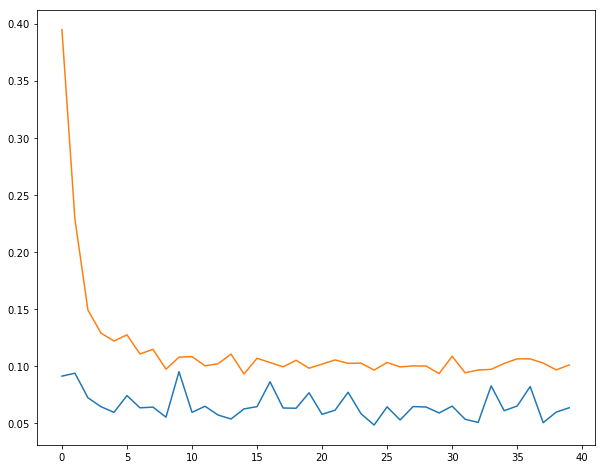

In [16]:
from neuralNetwork2 import *
from neuralNetwork3 import *
from weight_init import *
DEBUG_MODE = True
if DEBUG_MODE:
    NUM_HIDEN1 = 100
    NUM_HIDEN2 = 32
    DROPOUT = 0.5
    NUM_EPOCH = 40000

use_gpu = torch.cuda.is_available()
print("use gpu:",use_gpu)
model = neuralNetwork2(num_input,NUM_HIDEN1,1,DROPOUT)
model.apply(weight_init)
try:
    model.load_state_dict(torch.load('./model/neuralNetwork2.pth'))
except:
    pass
if use_gpu:
    model = model.cuda()

# 定义loss和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 开始训练
losses_train  = []
losses_test = []


for epoch in range(NUM_EPOCH):
    model.train()
    for i,data in enumerate(train_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 1000 == 0:
        model.eval()
        with torch.no_grad():
            if use_gpu:
                x_test = x_test.cuda()
                y_test = y_test.cuda()
            predict = model(x_test)
            loss_test = criterion(predict, y_test)
        print(f'step:[{epoch+1}], train loss: {loss.item():.6f}, test loss: {loss_test.item():.6f}')
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

plt.figure(figsize = (10,8))
plt.plot(losses_train,label = "train loss")
plt.plot(losses_test,label = "teset loss")
plt.show()
torch.save(model.state_dict(), './model/neuralNetwork2.pth')

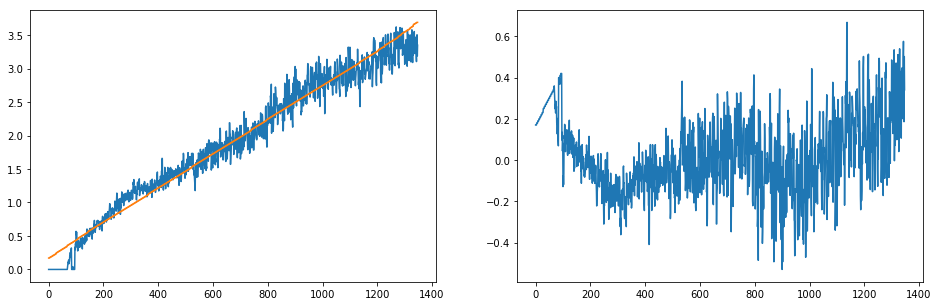

In [17]:
model.eval()
with torch.no_grad():
    x_train = x_train.cuda()
    predict = model(x_train)
predict = predict.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_train)
plt.subplot(122)
plt.plot((y_train-predict))
# a = train_df["temperature"].values
# plt.plot(a[:350]-0.5)
plt.show()

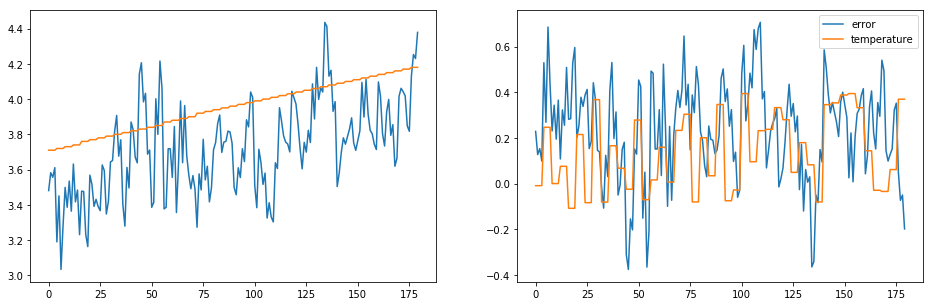

In [18]:
model.eval()
with torch.no_grad():
    x_test = x_test.cuda()
    predict = model(x_test)
predict = predict.cpu()
y_test = y_test.cpu()
x_test = x_test.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_test)
plt.subplot(122)
plt.plot((y_test-predict),label = "error")
a = train_df["temperature"].values
plt.plot(x_test[:,-1]-0.5,label = "temperature")
plt.legend()
plt.show()